In [1]:
from pyGDM2 import structures
from pyGDM2 import fields
from pyGDM2 import core
from pyGDM2 import propagators
from pyGDM2 import tools
from pyGDM2 import linear
from pyGDM2 import visu

import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from ase.io import read
import ase

sys.path.insert(0, 'Light/'); sys.path.insert(0, 'Building/')
from Light import Epsilon_ExpClass #For optical response with the pygdm package 

In [2]:
def Optimise(Step, g, m):
    Struct = structures.struct(Step, g, m, verbose = False, normalization="hex")

    while len(Struct.geometry) < len(g):
        Step -= 0.01
        Struct = structures.struct(Step, g, m, verbose = False, normalization="hex")
    return Struct

In [3]:
Strut = read("Structures/Pt147Dh441_rlx.xyz")
ele = Strut.get_chemical_symbols()
Ele = list(set(ele))
Strut.positions -= Strut.get_center_of_mass()
xyz = Strut.positions
g = xyz
m = len(g)*[getattr(Epsilon_ExpClass, Ele[0])()]

Struct = Optimise(2.77, g, m)

c:\CMNP\CMNPs-main\venv\lib\site-packages\pyGDM2\tools.py:821: UserWarning: Inconsistent structure!!! 147 of 147 dipoles don't match with step=2.77nm.
  warnings.warn("Inconsistent structure!!! {} of {} dipoles don't match with step={:.2f}nm.".format(
c:\CMNP\CMNPs-main\venv\lib\site-packages\pyGDM2\structures.py:176: UserWarning: using only consistent part of structure. Please verify the geometry.
  warnings.warn(
c:\CMNP\CMNPs-main\venv\lib\site-packages\pyGDM2\structures.py:217: UserWarning: Emtpy structure geometry.
  warnings.warn("Emtpy structure geometry.")
c:\CMNP\CMNPs-main\venv\lib\site-packages\numpy\lib\_function_base_impl.py:562: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\CMNP\CMNPs-main\venv\lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\CMNP\CMNPs-main\venv\lib\site-packages\pyGDM2\tools.py:821: UserWarning: Inconsistent structure!!! 147 of 

In [4]:
field_generator = fields.plane_wave
wavelengths = np.linspace(300, 800, 201)

kwargs_L = dict(inc_angle=180, E_s=1, E_p=1, phase_Es=[-np.pi/2]) #Defines the left circularly polarized light coming in the xy plane along z in the positive direction
efield_L = fields.efield(field_generator, wavelengths=wavelengths, kwargs=kwargs_L)
dyads = propagators.DyadsQuasistatic123(n1=1) #Vacuum
sim_L = core.simulation(Struct, efield_L, dyads)
sim_L.scatter(verbose=False)


kwargs_R = dict(inc_angle=180, E_s=1, E_p=1, phase_Es=[ np.pi/2]) #Defines the right circularly polarized light coming in the xy plane along z in the positive direction
efield_R = fields.efield(field_generator, wavelengths=wavelengths, kwargs=kwargs_R)
dyads = propagators.DyadsQuasistatic123(n1=1) #Vacuum
sim_R = core.simulation(Struct, efield_R, dyads)
sim_R.scatter(verbose=False)

1

config 0 : {'E_p': 1, 'E_s': 1, 'inc_angle': 180, 'phase_Es': -1.5707963267948966}
Significant local maxima:
Value: 33.012125940756725, Index: 32


Text(0, 0.5, '$\\sigma_{ext}$ (nm$^2$)')

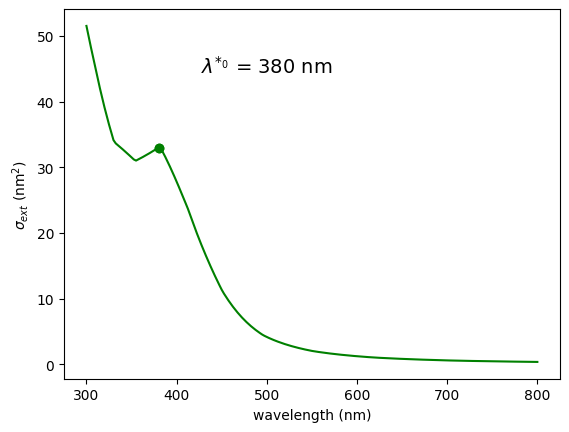

In [5]:
field_kwargs_L = tools.get_possible_field_params_spectra(sim_L)
for i, conf in enumerate(field_kwargs_L):
    print("config", i, ":", conf)
wl, spectrum_L = tools.calculate_spectrum(sim_L,field_kwargs_L[0] , linear.extinct)

spectrum_L = spectrum_L.T

peaks, _ = find_peaks(spectrum_L[0], height=0.05*np.amax(spectrum_L[0]))
# Print the significant local maxima
print("Significant local maxima:")
for peak in peaks:
    print(f"Value: {spectrum_L[0][peak]}, Index: {peak}")

plt.plot(wl, spectrum_L[0], 'g-', label='ext.')
plt.plot(wl[peaks], spectrum_L[0][peaks], "o", color = 'g')
for i,peak in enumerate(peaks):
    plt.text(500, 0.85*np.amax(spectrum_L[0])-0.075*np.amax(spectrum_L[0])*i, "$\lambda^{*_{%s}}$ = " f'{wl[peak]:.0f} nm' %(i), ha='center', va='bottom', fontsize = 14)

plt.plot(wl[peaks], spectrum_L[0][peaks], "o", color='g', label='peaks')
plt.xlabel("wavelength (nm)")
plt.ylabel("$\sigma_{ext}$ (nm$^2$)")



In [6]:
def cmnp_plot(
              wl_target = 400, 
              z_probe = 0,
              projection = "XY"
              ):
    
    idx = tools.get_closest_field_index(sim_L, dict(wavelength=wl_target))

    wl, Cspec_L = tools.calculate_spectrum(sim_L, 0, linear.optical_chirality, r_probe=[[0,0,z_probe]])
    C_spec_L = Cspec_L.T
    
    r_probe_L = tools.generate_NF_map(-40,+40,201, -40,40,201, Z0=z_probe)
    C_L_t = linear.optical_chirality(sim_L, idx, r_probe_L, which_field='t')
    Es_L, Et_L, E0_L, Bs_L, Bt_L, B0_L  = linear.nearfield(sim_L, idx, r_probe=r_probe_L, which_fields=['es', 'et', 'e0', 'bs', 'bt', 'b0'])
    E_max_L = np.amax(np.abs(Es_L[:,3].reshape(201,201))**2 + np.abs(Es_L[:,4].reshape(201,201))**2 + np.abs(Es_L[:,5].reshape(201,201))**2)
    wl, Cspec_R = tools.calculate_spectrum(sim_R, 0, linear.optical_chirality, r_probe=[[0,0,z_probe]])
    C_spec_R = Cspec_R.T
    
    r_probe_R = tools.generate_NF_map(-40,+40,201, -40,40,201, Z0=z_probe)
    C_R_t = linear.optical_chirality(sim_R, idx, r_probe_R, which_field='t')
    Es_R, Et_R, E0_R, Bs_R, Bt_R, B0_R  = linear.nearfield(sim_R, idx, r_probe=r_probe_R, which_fields=['es', 'et', 'e0', 'bs', 'bt', 'b0'])
    E_max_R = np.amax(np.abs(Es_R[:,3].reshape(201,201))**2 + np.abs(Es_R[:,4].reshape(201,201))**2 + np.abs(Es_R[:,5].reshape(201,201))**2)


    fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
    fig.set_size_inches(10, 10)
    fig.subplots_adjust(hspace=0.0, wspace=0.0)
    
    im_EL = visu.vectorfield_color(Et_L, show=0, ax=axs[0,0], cmap="seismic", vmin=0, vmax = int(E_max_L)+1, projection=projection)
    #visu.structure_contour(sim_L, color='k', show=0, lw = 10, ax=axs[0,0], projection=projection)
    im_CL = visu.scalarfield(C_L_t, cmap='seismic', show=0, interpolation='nearest',  vmin=-5, vmax=5, ax=axs[1,0], projection=projection)
    #visu.structure_contour(sim_L, color='k', show=0, lw = 10, ax=axs[1,0], projection=projection)
    
    im_ER = visu.vectorfield_color(Et_R, show=0, ax=axs[0,1], cmap='seismic', vmin=0, vmax = int(E_max_R)+1, projection=projection)
    #visu.structure_contour(sim_R, color='k', show=0, lw = 10, ax=axs[0,1], projection=projection)
    im_CR = visu.scalarfield(C_R_t, cmap='seismic', show=0, interpolation='nearest', vmin=-5, vmax=5, ax=axs[1,1], projection=projection)
    #visu.structure_contour(sim_R, color='k', show=0, lw = 10, ax=axs[1,1], projection=projection)

    axs[0,1].yaxis.set_label_position("right")
    axs[0,1].yaxis.tick_right()
    
    axs[1,1].yaxis.set_label_position("right")
    axs[1,1].yaxis.tick_right()
    
    axs[0,0].xaxis.set_label_position("top")
    axs[0,0].xaxis.tick_top()
    
    axs[0,1].xaxis.set_label_position("top")
    axs[0,1].xaxis.tick_top()
    
    axs[0,1].tick_params(labeltop=True)
    axs[0,0].tick_params(labeltop=True)
    
    axs[0,1].tick_params(labelright=True)
    axs[1,1].tick_params(labelright=True)
    
    #fig.subplots_adjust(wspace=0.025, hspace=0.025)
    cbar_ax_cpl = fig.add_axes([0.125, 0.96, 0.725, 0.02])
    cax_cpl = fig.colorbar(im_ER, cax=cbar_ax_cpl,  orientation='horizontal')    
    cbar_ax_cpl.xaxis.set_ticks_position('top')
    
    cbar_ax_e = fig.add_axes([0.125, 0.025, 0.725, 0.02])
    cax_e = fig.colorbar(im_CR, cax=cbar_ax_e, orientation='horizontal')
    cbar_ax_e.xaxis.set_ticks_position('bottom')
    
    
    axs[0,0].text(0.5, 1.1, 'Left CPL', ha='center', va='center', fontsize = 16, transform=axs[0,0].transAxes)
    axs[0,1].text(0.5, 1.1, 'Right CPL', ha='center', va='center', fontsize = 16, transform=axs[0,1].transAxes)
    
    fig.text(0.5, 1.01,'$\mathcal{E}_{tot}$ (V/m)', verticalalignment='center', horizontalalignment='center', fontsize = 16)
    fig.text(0.5, -0.01,'$\mathcal{C}_{tot}$ (N/m$^{3}$)', verticalalignment='center', horizontalalignment='center', fontsize = 16)
    axs[0,0].text(-45,50, f'$\lambda$ = ' f'{wl[peak]:.0f} nm', fontsize = 14)
    axs[0,1].text(17.5,50, f'z = {z_probe} nm', fontsize = 14)
    axs = axs.T.flatten()
    for i,ax in enumerate(axs):
        for atom in Strut.positions:
            ax.scatter(atom[0], atom[1], color='k', s=500, marker='o')
        ax.set_aspect('equal')
    plt.show()

In [ ]:

def cmnp_plot(#atom graph, not currently using
              wl_target = 320, 
              z_probe = 0,
              projection = "XY"
              ):
    
    idx = tools.get_closest_field_index(sim_L, dict(wavelength=wl_target))

    wl, Cspec_L = tools.calculate_spectrum(sim_L, 0, linear.optical_chirality, r_probe=[[0,0,z_probe]])
    C_spec_L = Cspec_L.T
    
    r_probe_L = tools.generate_NF_map(-40,+40,201, -40,40,201, Z0=z_probe)
    C_L_t = linear.optical_chirality(sim_L, idx, r_probe_L, which_field='t')
    Es_L, Et_L, E0_L, Bs_L, Bt_L, B0_L  = linear.nearfield(sim_L, idx, r_probe=r_probe_L, which_fields=['es', 'et', 'e0', 'bs', 'bt', 'b0'])
    E_max_L = np.amax(np.abs(Es_L[:,3].reshape(201,201))**2 + np.abs(Es_L[:,4].reshape(201,201))**2 + np.abs(Es_L[:,5].reshape(201,201))**2)
    wl, Cspec_R = tools.calculate_spectrum(sim_R, 0, linear.optical_chirality, r_probe=[[0,0,z_probe]])
    C_spec_R = Cspec_R.T
    
    r_probe_R = tools.generate_NF_map(-40,+40,201, -40,40,201, Z0=z_probe)
    C_R_t = linear.optical_chirality(sim_R, idx, r_probe_R, which_field='t')
    Es_R, Et_R, E0_R, Bs_R, Bt_R, B0_R  = linear.nearfield(sim_R, idx, r_probe=r_probe_R, which_fields=['es', 'et', 'e0', 'bs', 'bt', 'b0'])
    E_max_R = np.amax(np.abs(Es_R[:,3].reshape(201,201))**2 + np.abs(Es_R[:,4].reshape(201,201))**2 + np.abs(Es_R[:,5].reshape(201,201))**2)


    fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
    fig.set_size_inches(9, 9)
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    
    plt.sca(axs[0,0])
    im_EL = visu.vectorfield_color(Et_L, show=0, cmap="seismic", vmin=0, vmax = int(E_max_L)+1, projection=projection)
    visu.structure_contour(sim_L, color='k', show=0, lw = 10, projection=projection)
    plt.sca(axs[1,0])
    im_CL = visu.scalarfield(C_L_t, cmap='seismic', show=0, interpolation='nearest',  vmin=-5, vmax=5, projection=projection)
    visu.structure_contour(sim_L, color='k', show=0, lw = 10, projection=projection)
    plt.sca(axs[0,1])
    im_ER = visu.vectorfield_color(Et_R, show=0, cmap='seismic', vmin=0, vmax = int(E_max_R)+1, projection=projection)
    visu.structure_contour(sim_R, color='k', show=0, lw = 10, projection=projection)
    plt.sca(axs[1,1])
    im_CR = visu.scalarfield(C_R_t, cmap='seismic', show=0, interpolation='nearest', vmin=-5, vmax=5, projection=projection)
    visu.structure_contour(sim_R, color='k', show=0, lw = 10, projection=projection)

    axs[0,1].yaxis.set_label_position("right")
    axs[0,1].yaxis.tick_right()
    
    axs[1,1].yaxis.set_label_position("right")
    axs[1,1].yaxis.tick_right()
    
    axs[0,0].xaxis.set_label_position("top")
    axs[0,0].xaxis.tick_top()
    
    axs[0,1].xaxis.set_label_position("top")
    axs[0,1].xaxis.tick_top()
    
    axs[0,1].tick_params(labeltop=True)
    axs[0,0].tick_params(labeltop=True)
    
    axs[0,1].tick_params(labelright=True)
    axs[1,1].tick_params(labelright=True)
    
    #fig.subplots_adjust(wspace=0.025, hspace=0.025)
    cbar_ax_cpl = fig.add_axes([0.125, 0.95, 0.725, 0.02])
    cax_cpl = fig.colorbar(im_ER, cax=cbar_ax_cpl,  orientation='horizontal')    
    cbar_ax_cpl.xaxis.set_ticks_position('top')
    
    cbar_ax_e = fig.add_axes([0.125, 0.025, 0.725, 0.02])
    cax_e = fig.colorbar(im_CR, cax=cbar_ax_e, orientation='horizontal')
    cbar_ax_e.xaxis.set_ticks_position('bottom')
    
    
    axs[0,0].text(0.5, 1.1, 'Left CPL', ha='center', va='center', fontsize = 16, transform=axs[0,0].transAxes)
    axs[0,1].text(0.5, 1.1, 'Right CPL', ha='center', va='center', fontsize = 16, transform=axs[0,1].transAxes)
    
    fig.text(0.5, 1.01,'$\mathcal{E}_{tot}$ (V/m)', verticalalignment='center', horizontalalignment='center', fontsize = 16)
    fig.text(0.5, -0.01,'$\mathcal{C}_{tot}$ (N/m$^{3}$)', verticalalignment='center', horizontalalignment='center', fontsize = 16)
    axs[0,0].text(-45,50, f'$\lambda$ = ' f'{wl[peak]:.0f} nm', fontsize = 14)
    axs[0,1].text(17.5,50, f'z = {z_probe} nm', fontsize = 14)
    axs = axs.T.flatten()
    for i,ax in enumerate(axs):
        for atom in Strut.positions:
            ax.scatter(atom[0], atom[1], color='k', s=500, marker='o', alpha = 0.5)
        ax.set_aspect('equal')
    plt.show()

In [7]:
idx = tools.get_closest_field_index(sim_L, dict(wavelength=380))

r_probe_R = tools.generate_NF_map(-40,+40,201, -40,40,201, Z0=0)
C_R_t = linear.optical_chirality(sim_R, idx, r_probe_R, which_field='t')
Es_R, Et_R, E0_R, Bs_R, Bt_R, B0_R  = linear.nearfield(sim_R, idx, r_probe=r_probe_R, which_fields=['es', 'et', 'e0', 'bs', 'bt', 'b0'])

c:\CMNP\CMNPs-main\venv\lib\site-packages\pyGDM2\linear.py:616: UserWarning: No H-values inside structure calculated. Setting internal magnetic field zero. Please run 'scatter' with the according parameter.
  warnings.warn("No H-values inside structure calculated. Setting internal magnetic field zero. " +
c:\CMNP\CMNPs-main\venv\lib\site-packages\pyGDM2\linear.py:616: UserWarning: No H-values inside structure calculated. Setting internal magnetic field zero. Please run 'scatter' with the according parameter.
  warnings.warn("No H-values inside structure calculated. Setting internal magnetic field zero. " +


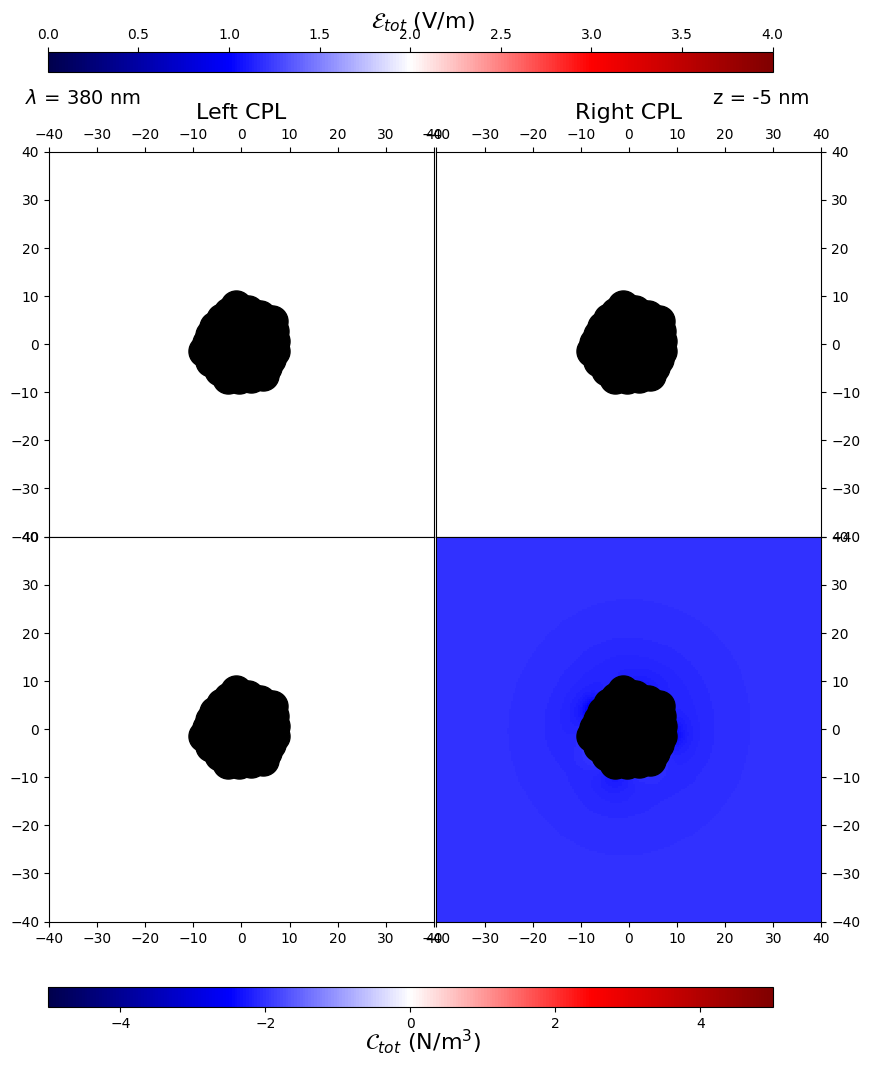

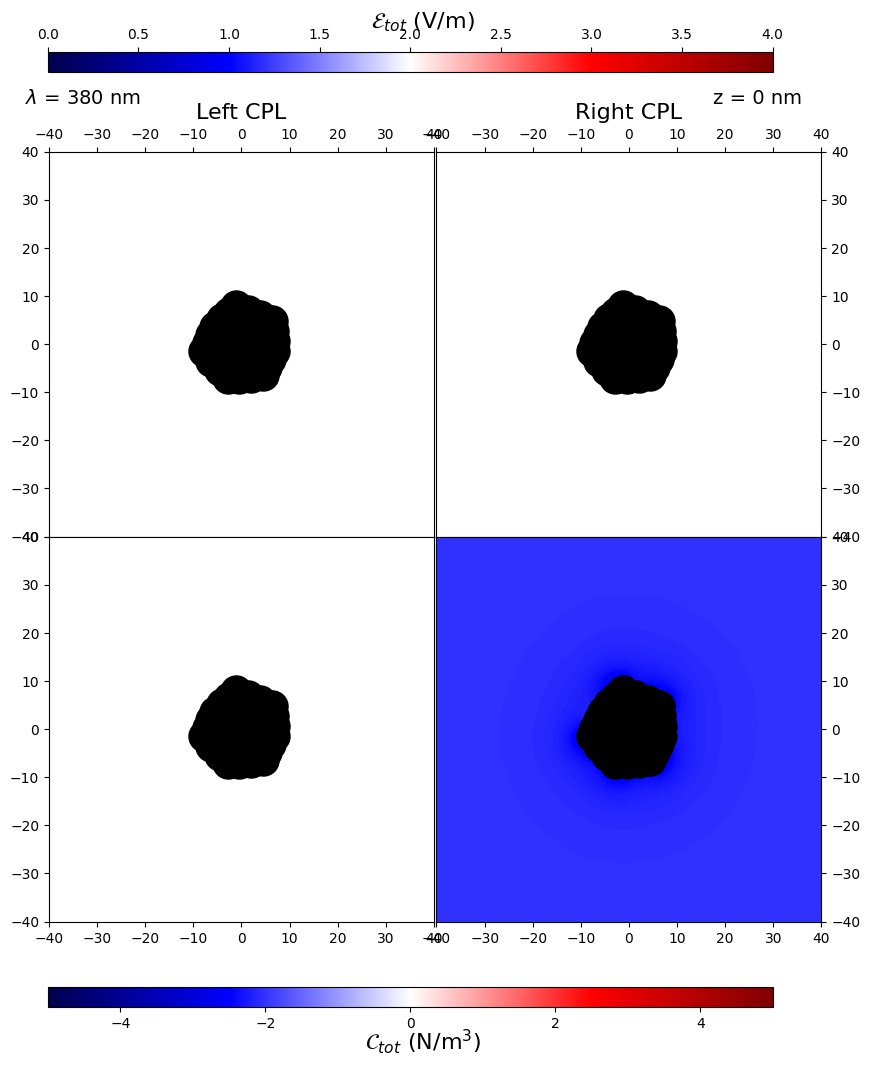

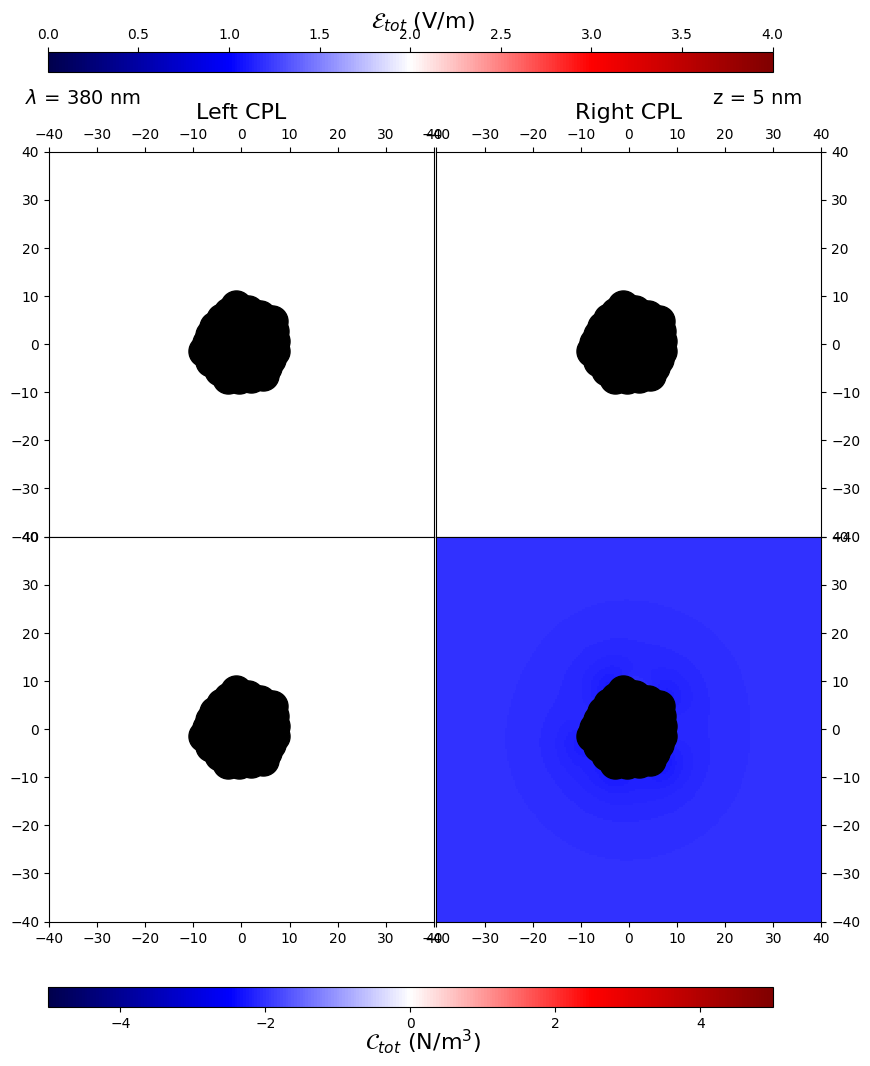

In [ ]:
for wavelength in wl[peaks]:
    for z in [-5, 0, 5]:
        cmnp_plot(wavelength, z)